In [2]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.densenet import DenseNet201
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

## Load In the Dataset

In [3]:
X_train = np.load("256_192_train.npy")

In [4]:
y_train = np.load("train_labels.npy")

In [5]:
X_val = np.load("256_192_val.npy")

In [6]:
y_val = np.load("val_labels.npy")

In [6]:
X_train.shape, X_val.shape

((37989, 256, 192, 3), (902, 192, 256, 3))

In [7]:
y_train.shape, y_val.shape

((37989,), (902,))

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [9]:
y_train.shape, y_val.shape

((37989, 7), (902, 7))

## Load In the Model

In [11]:
pre_trained_model = DenseNet201(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

In [12]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True
    
print(len(pre_trained_model.layers))

input_1
zero_padding2d
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_1
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3_b

In [13]:
last_layer = pre_trained_model.get_layer('relu')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 1920)


## Define the Model

In [14]:
# Flattening the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Adding a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Adding a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Adding a final softmax layer for classification
x = layers.Dense(7, activation='softmax')(x)
# Configuring and compiling the model
model = Model(pre_trained_model.input, x)
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 198, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 96, 128, 64)  9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 96, 128, 64)  256         ['conv1/conv[0][0]']         

## Training

### Feature Extraction

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.2, 
                                            min_lr=0.000001, cooldown=2)

In [16]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest', brightness_range=[0.8,1.2], rescale=1./255, horizontal_flip=True, vertical_flip=True)

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [17]:
batch_size = 64
epochs = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[lr_scheduler])

Epoch 1/3
593/593 [==============================] - 301s 483ms/step - loss: 1.4495 - accuracy: 0.6250 - val_loss: 0.9348 - val_accuracy: 0.6786
Epoch 2/3
593/593 [==============================] - 274s 450ms/step - loss: 0.9443 - accuracy: 0.6809 - val_loss: 0.8814 - val_accuracy: 0.6775
Epoch 3/3
593/593 [==============================] - 593s 420ms/step - loss: 0.8547 - accuracy: 0.7043 - val_loss: 0.8115 - val_accuracy: 0.6975


In [ ]:
# Unfreeze the top layers of the model
pre_trained_model.trainable = True
fine_tune_at = 280

for layer in pre_trained_model.layers[:fine_tune_at]:
    layer.trainable = False

### Retraining

In [18]:
for layer in pre_trained_model.layers:
    layer.trainable = True

In [19]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

c:\Users\chara_eoccfea\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 198, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 96, 128, 64)  9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 96, 128, 64)  256         ['conv1/conv[0][0]']         

In [23]:
batch_size = 64
epochs = 20
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=val_datagen.flow(X_val, y_val),
    verbose=1,
    steps_per_epoch=X_train.shape[0] // batch_size,
    validation_steps=X_val.shape[0] // batch_size,
    callbacks=[learning_rate_reduction, lr_scheduler, early_stopping]
)

Epoch 1/20
593/593 [==============================] - 584s 2s/step - loss: 0.7455 - acc: 0.7386 - val_loss: 0.6257 - val_acc: 0.7232
Epoch 2/20
593/593 [==============================] - 537s 1s/step - loss: 0.5644 - acc: 0.7980 - val_loss: 0.3695 - val_acc: 0.8126
Epoch 3/20
593/593 [==============================] - 535s 1s/step - loss: 0.4717 - acc: 0.8305 - val_loss: 0.3038 - val_acc: 0.7954
Epoch 4/20
593/593 [==============================] - 534s 1s/step - loss: 0.3995 - acc: 0.8620 - val_loss: 0.3201 - val_acc: 0.7793
Epoch 5/20
593/593 [==============================] - 533s 1s/step - loss: 0.3614 - acc: 0.8704 - val_loss: 0.2384 - val_acc: 0.8425
Epoch 6/20
593/593 [==============================] - 533s 1s/step - loss: 0.3287 - acc: 0.8809 - val_loss: 0.3623 - val_acc: 0.7966
Epoch 7/20
593/593 [==============================] - 533s 1s/step - loss: 0.2892 - acc: 0.8975 - val_loss: 0.3001 - val_acc: 0.8402
Epoch 8/20
593/593 [==============================] - 533s 1s/step - 

In [24]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 4s 118ms/step - loss: 0.2343 - acc: 0.9003
Validation: accuracy = 0.920310  ;  loss_v = 0.134328


## Testing

In [25]:
X_test = np.load("256_192_test.npy")

In [26]:
y_test = np.load("test_labels.npy")
y_test = to_categorical(y_test)

In [27]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 4s 120ms/step - loss: 0.4355 - acc: 0.8772
Test: accuracy = 0.937245  ;  loss = 0.125454


In [28]:
model.save("DenseNet.h5")

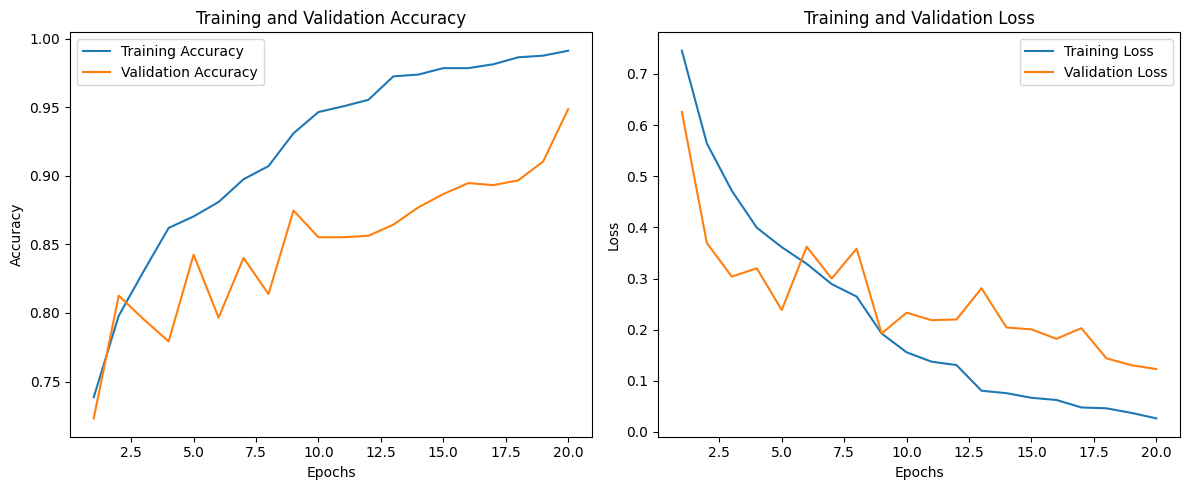

In [5]:
# Retrieving a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieving a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Getting number of epochs
epochs = range(len(acc))

# Plotting training and validation accuracy per epoch
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()